<a href="https://colab.research.google.com/github/ICBI/BISR_Tutorials/blob/main/scRNA_seq/Notebook_SCRNAseq_Seurat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial - single cell RNA-seq (scRNA-seq) data analysis

Authors: Krithika Bhuvaneshwar, Yuriy Gusev

Affiliation: Innovation Center For Biomedical Informatics (ICBI), and Biomedical Informatics Shared Resource (BISR) at Georgetown University Medical Center (GUMC)

***More about our research work:***
* *ICBI: https://icbi.georgetown.edu*
* *BISR: https://icbi.georgetown.edu/bisr/ and https://lombardi.georgetown.edu/research/sharedresources/bbsr/*


## General Steps in analysis
Based on the workflow mentioned in the e-book "Orchestrating Single-Cell Analysis with Bioconductor"
* Removal of low-quality cells
* Normalization and log-transformation
* Modeling of the mean-variance trend across genes
* A principal components analysis on the highly variable genes
* Clustering with graph-based methods
* Dimensionality reductions (t-SNE/UMAP)
* Marker detection for each cluster
* Make custom cell selections and detect markers for this selection
* Cell type annotation for each cluster across user selected reference datasets
* Perform Integration or Batch correction using MNN correction.
* Support Multi-modal analysis for Cite-seq data
* Perform analysis on subsets (filter based on cell annotation)





## Steps for anlaysis using Seurat

* Setup the Seurat Object
* Standard pre-processing workflow
* Normalizing the data
* Identification of highly variable features (feature selection)
* Scaling the data
* Perform linear dimensional reduction
* Determine the ‘dimensionality’ of the dataset
* Cluster the cells
* Run non-linear dimensional reduction (UMAP/tSNE)
* Finding differentially expressed features (cluster biomarkers)
* Assigning cell type identity to clusters

##  Before we start

### Change Run type to R
If using google colab, change the colab runtype environment to R (default is python). Go to  Runtime -> Change runtime type -> In the "Notebook settings", change environment to "R"

### Mount google drive

In [6]:
### Mount google drive
install.packages("googledrive") #only need to install occasionally install.packages(“httpuv”)
library("googledrive")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [7]:
#may update python version  #occasionally
if (file.exists("/usr/local/lib/python3.7/dist-packages/google/colab/_ipython.py")) {
  install.packages("R.utils")
  library("R.utils")
  library("httr")
  my_check <- function() {return(TRUE)}
  reassignInPackage("is_interactive", pkgName = "httr", my_check)
  options(rlang_interactive=TRUE)
}

## Example using Seurat workflow in R
In this example, we will use the Seurat package (Link: https://satijalab.org/seurat/articles/get_started.html)

Citation for this tutorial: https://satijalab.org/seurat/articles/pbmc3k_tutorial.html


 ## Dataset
Dataset of Peripheral Blood Mononuclear Cells (PBMC) freely available from 10X Genomics. There are 2,700 single cells that were sequenced on the Illumina NextSeq 500.
The `cellranger` pipeline from 10X takes was applied on the raw fastq files

The data can be obtained from this page https://satijalab.org/seurat/articles/pbmc3k_tutorial.html, and has been uploaded to this github page.

### Note
Please download the input data files from either location listed above, and load it to your google drive folder `sample_data` that you can see on the left panel. Full path is `/content/sample_data/`

## Installation packages and dependencies
Takes several minutes to complete

In [2]:
install.packages("Seurat")

library(dplyr)
library(Seurat)
library(patchwork)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’, ‘plyr’, ‘tensor’, ‘BH’, ‘sitmo’, ‘globals’, ‘listenv’, ‘parallelly’, ‘zoo’, ‘htmlwidgets’, ‘lazyeval’, ‘crosstalk’, ‘promises’, ‘RcppTOML’, ‘here’, ‘gplots’, ‘reshape2’, ‘gridExtra’, ‘RcppArmadillo’, ‘sp’, ‘httpuv’, ‘xtable’, ‘sourcetools’, ‘later’, ‘spatstat.data’, ‘spatstat.random’, ‘spatstat.utils’, ‘spatstat.sparse’, ‘goftest’, ‘abind’, ‘deldir’, ‘polyclip’, ‘FNN’, ‘dqrng’, ‘cowplot’, ‘fitdistrplus’, ‘future’, ‘future.apply’, ‘ggrepel’, ‘ggridges’, ‘ica’, ‘igraph’, ‘irlba’, ‘leiden’, ‘lmtest’, ‘matrixStats’, ‘miniUI’, ‘patchwork’, ‘pbapply’, ‘plotly’, ‘png’, ‘progressr’, ‘RANN’, ‘Rcpp’, ‘RcppAnnoy’, ‘reticulate’, ‘ROCR’, ‘Rtsne’, ‘scattermore’, ‘sctransform’, ‘SeuratObject’, ‘shiny’, ‘spatstat.explore’, ‘spatstat.geom’, ‘uwot’, ‘RcppEigen’, ‘RcppProgress’


The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
whic

## Load input data

We start by reading in the data. The `Read10X()` function reads in the output of the cellranger pipeline from 10X, returning a **unique molecular identified (UMI) count matrix.**
The values in this matrix represent the number of molecules for each feature (i.e. gene; row) that are detected in each cell (column).

We next use the count matrix to create a **Seurat object.** The object serves as a container that contains both data (like the count matrix) and analysis (like PCA, or clustering results) for a single-cell dataset.  For example, the count matrix is stored in pbmc[["RNA"]]@counts.

* The `cellranger` pipeline from 10X takes the raw fastq files and processes it. For this tutorial, this step is already completed
* The `Read10X()` function reads in the output of the `cellranger` pipeline from 10X and returns a unique molecular identified (UMI) count matrix
* The values in this matrix represent the number of molecules for each feature (i.e. gene; row) that are detected in each cell (column).

## Important
Load input data to your google drive location. For this example, the path to input folder is `/content/sample_data/`. Can change path as needed in the URL below


In [11]:
# Set the PBMC data directory
pbmc.data <- Read10X(data.dir = "/content/sample_data/filtered_gene_bc_matrices/hg19/")

[1] 32738  2700

Learn more about this object

In [13]:
#Learn more about this object
print("Dimensions")
dim(pbmc.data)

#The object serves as a container that contains both data and meta data
print("Structure")
str(pbmc.data)

[1] "Dimensions"


[1] 32738  2700

[1] "Structure"
Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:2286884] 70 166 178 326 363 410 412 492 494 495 ...
  ..@ p       : int [1:2701] 0 781 2133 3264 4224 4746 5528 6311 7101 7634 ...
  ..@ Dim     : int [1:2] 32738 2700
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:32738] "MIR1302-10" "FAM138A" "OR4F5" "RP11-34P13.7" ...
  .. ..$ : chr [1:2700] "AAACATACAACCAC-1" "AAACATTGAGCTAC-1" "AAACATTGATCAGC-1" "AAACCGTGCTTCCG-1" ...
  ..@ x       : num [1:2286884] 1 1 2 1 1 1 1 41 1 1 ...
  ..@ factors : list()


Initialize the Seurat object with the raw (non-normalized count data) Include features detected in at least 3 cells

Use the count matrix to create a Seurat object. The object serves as a container that contains both data (like the count matrix) and analysis (like PCA, or clustering results) for a single-cell dataset. For example, the count matrix is stored in pbmc[["RNA"]]@counts.

In [14]:
# Initialize the Seurat object with the raw (non-normalized data).
pbmc <- CreateSeuratObject(counts = pbmc.data, ##Unnormalized data such as raw counts or TPM
    project = "pbmc3k", #Sets the project name for the Seurat object
    min.cells = 3, #Include features detected in at least this many cells
     min.features = 200) ##Include cells where at least this many features

dim(pbmc)

## An object of class Seurat
## 13714 features across 2700 samples within 1 assay
## Active assay: RNA (13714 features, 0 variable features)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


[1] 13714  2700

Get more information

In [15]:
# See the QC **metrics**
head(pbmc)

,orig.ident,nCount_RNA,nFeature_RNA
,<fct>,<dbl>,<int>
AAACATACAACCAC-1,pbmc3k,2419,779
AAACATTGAGCTAC-1,pbmc3k,4903,1352
AAACATTGATCAGC-1,pbmc3k,3147,1129
AAACCGTGCTTCCG-1,pbmc3k,2639,960
AAACCGTGTATGCG-1,pbmc3k,980,521
AAACGCACTGGTAC-1,pbmc3k,2163,781
AAACGCTGACCAGT-1,pbmc3k,2175,782
AAACGCTGGTTCTT-1,pbmc3k,2260,790
AAACGCTGTAGCCA-1,pbmc3k,1275,532


Lets examine a few genes in the first thirty cells

The "." values in the matrix represent 0s (no molecules detected). Since most values in an scRNA-seq matrix are 0, Seurat uses a sparse-matrix representation whenever possible. This results in significant memory and speed savings for Drop-seq/inDrop/10x data.

In [16]:
# Lets examine a few genes in the first thirty cells
pbmc.data[c("CD3D", "TCL1A", "MS4A1"), 1:30]

dense.size <- object.size(as.matrix(pbmc.data))
dense.size

#pbmc.data stored as sparse matrix
sparse.size <- object.size(pbmc.data)
sparse.size

  [[ suppressing 30 column names ‘AAACATACAACCAC-1’, ‘AAACATTGAGCTAC-1’, ‘AAACATTGATCAGC-1’ ... ]]



3 x 30 sparse Matrix of class "dgCMatrix"
                                                                   
CD3D  4 . 10 . . 1 2 3 1 . . 2 7 1 . . 1 3 . 2  3 . . . . . 3 4 1 5
TCL1A . .  . . . . . . 1 . . . . . . . . . . .  . 1 . . . . . . . .
MS4A1 . 6  . . . . . . 1 1 1 . . . . . . . . . 36 1 2 . . 2 . . . .

709591472 bytes

29905192 bytes

## QC and selecting cells for further analysis

Seurat allows you to easily explore QC metrics and filter cells based on any user-defined criteria. A few QC metrics commonly used by the community include

* The number of unique genes detected in each cell
    * Low-quality cells or empty droplets will often have very few genes
    * Cell doublets or multiplets may exhibit an aberrantly high gene count
* Similarly, the total number of molecules detected within a cell (correlates strongly with unique genes)
* The percentage of reads that map to the mitochondrial genome
    * Low-quality / dying cells often exhibit extensive mitochondrial contamination
    * We calculate mitochondrial QC metrics with the PercentageFeatureSet() function, which calculates the percentage of counts originating from a set of features
    * We use the set of all genes starting with MT- as a set of mitochondrial genes


In [17]:
# The [[ operator can add columns to object metadata. This is a great place to stash QC stats
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")


Show QC metrics for the first 5 cells

In [19]:
# Show QC metrics for the first 5 cells
head(pbmc@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898


### Visualize QC metrics

As a violin plot

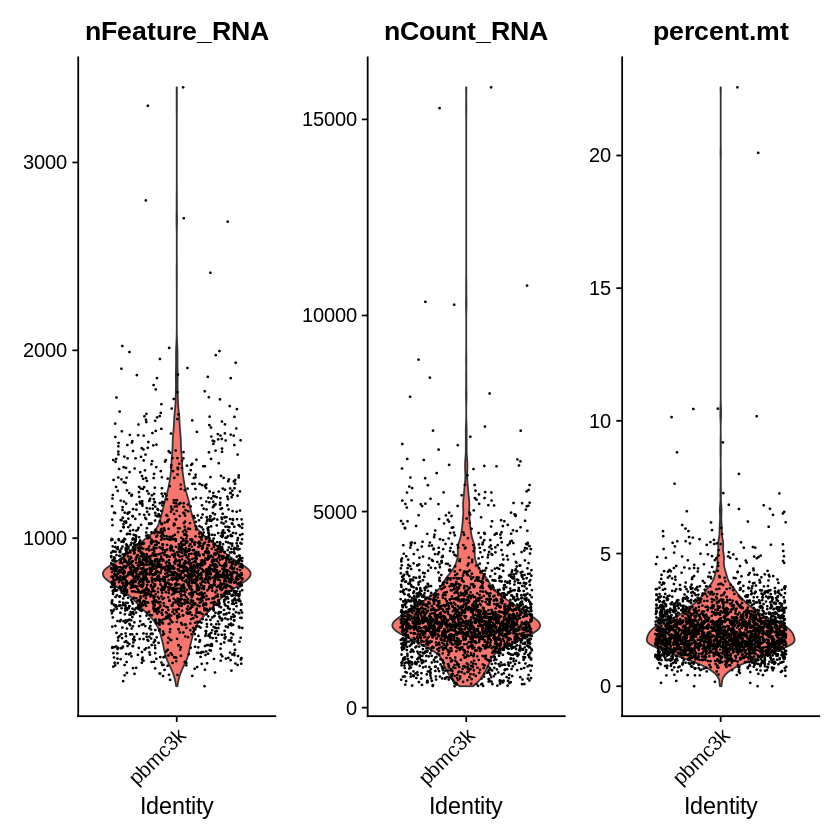

In [20]:
# Visualize QC metrics as a violin plot
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"),
        ncol = 3)

FeatureScatter is typically used to visualize feature-feature relationships, but can be used
for anything calculated by the object, i.e. columns in object metadata, PC scores etc.


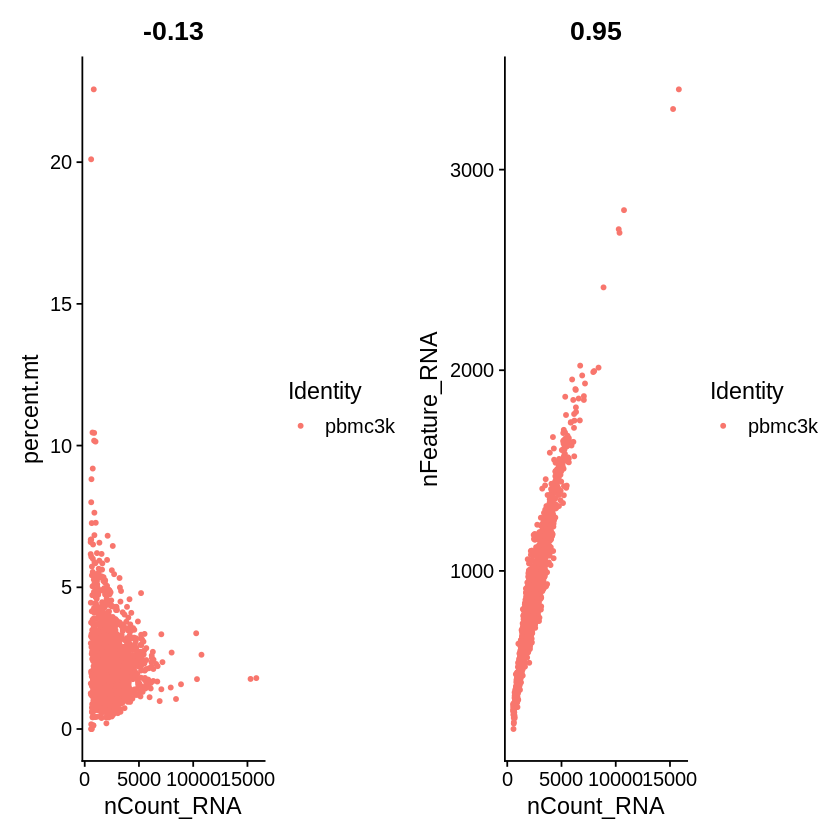

In [21]:
plot1 <- FeatureScatter(pbmc,
                        feature1 = "nCount_RNA",
                        feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc,
                        feature1 = "nCount_RNA",
                        feature2 = "nFeature_RNA")
plot1 + plot2

## Filtering

* We filter cells that have unique feature counts over 2,500 or less than 200
* We filter cells that have >5% mitochondrial counts




In [22]:
pbmc2 <- subset(pbmc,
  subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)
dim(pbmc2)
#number of samples went from 2700 to 2638

[1] 13714  2638

Number of samples went from 2700 to 2638

## Normalizing the data

After removing unwanted cells from the dataset, the next step is to normalize the data. By default, we employ a global-scaling normalization method “LogNormalize” that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result. Normalized values are stored in pbmc[["RNA"]]@data.

In [23]:
pbmc3 <- NormalizeData(pbmc2,
                      normalization.method = "LogNormalize",
                      scale.factor = 10000)

#same step for normlization as above
#pbmc <- NormalizeData(pbmc)

dim(pbmc3)
#13714  2638


[1] 13714  2638

## Identification of highly variable features (feature selection)
We next calculate a subset of features that exhibit high cell-to-cell variation in the dataset (i.e, they are highly expressed in some cells, and lowly expressed in others). We and others have found that focusing on these genes in downstream analysis helps to highlight biological signal in single-cell datasets.

The procedure in Seurat is described in detail here, and improves on previous versions by directly modeling the mean-variance relationship inherent in single-cell data, and is implemented in the FindVariableFeatures() function. By default, we return 2,000 features per dataset. These will be used in downstream analysis, like PCA.

[1] 13714  2638

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


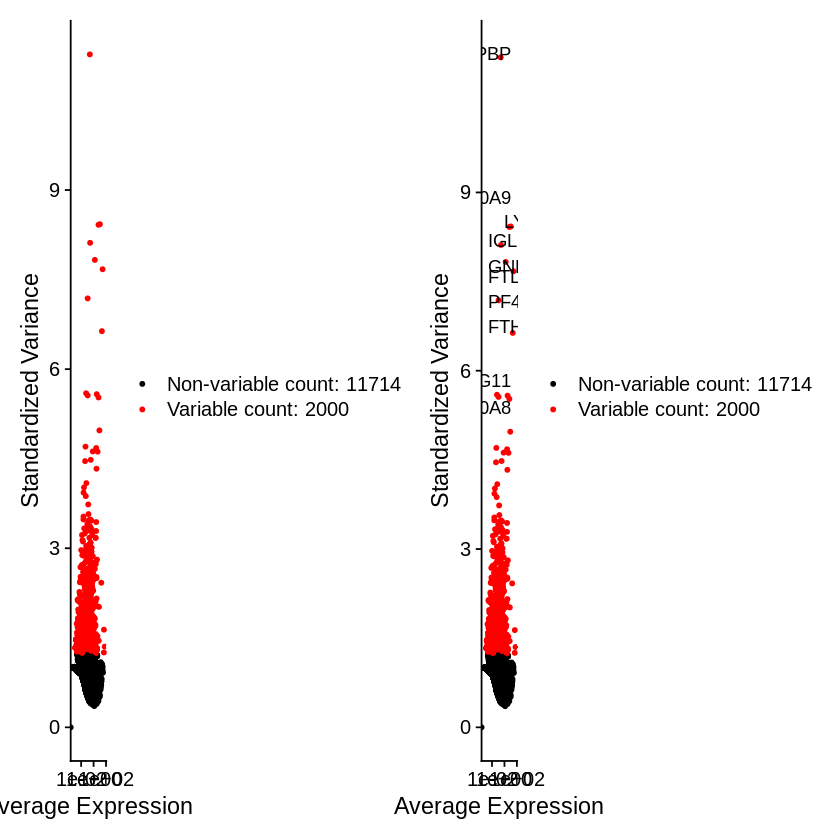

In [24]:
pbmc4 <- FindVariableFeatures(pbmc3,
                             selection.method = "vst",
                             nfeatures = 2000)

dim(pbmc4) #13714  2638

In [27]:
# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc4), 10)

head(top10)

[1] "PPBP"   "LYZ"    "S100A9" "IGLL5"  "GNLY"   "FTL"

## Scaling the data
Next, we apply a linear transformation (‘scaling’) that is a standard pre-processing step prior to dimensional reduction techniques like PCA. The ScaleData() function:

* Shifts the expression of each gene, so that the mean expression across cells is 0
* Scales the expression of each gene, so that the variance across cells is 1
This step gives equal weight in downstream analyses, so that highly-expressed genes do not dominate
* The results of this are stored in pbmc[["RNA"]]@scale.data

In [28]:
all.genes <- rownames(pbmc4)
pbmc5 <- ScaleData(pbmc4, features = all.genes)

Centering and scaling data matrix



Scaling is an essential step in the Seurat workflow, but only on genes that will be used as input to PCA. Therefore, the default in ScaleData() is only to perform scaling on the previously identified variable features (2,000 by default). To do this, omit the features argument in the previous function call, i.e.
`pbmc <- ScaleData(pbmc) #only 2000 genes`.

Your PCA and clustering results will be unaffected. However, Seurat heatmaps (produced as shown below with DoHeatmap()) require genes in the heatmap to be scaled, to make sure highly-expressed genes don’t dominate the heatmap. To make sure we don’t leave any genes out of the heatmap later, we are scaling all genes in this tutorial.

### To ‘regress out’ heterogeneity associated with (for example) cell cycle stage, or mitochondrial contamination.
For particularly for advanced users who would like to use this functionality, we strongly recommend the use of the new normalization workflow, SCTransform(). The method is described in the paper, with a separate vignette using Seurat v3 here. As with ScaleData(), the function SCTransform() also includes a vars.to.regress parameter. https://satijalab.org/seurat/articles/sctransform_vignette.html

In [29]:
#remove unwanted sources of variation,
pbmc6 <- ScaleData(pbmc5, vars.to.regress = "percent.mt")

Regressing out percent.mt

Centering and scaling data matrix



## Perform linear dimensional reduction
Next we perform PCA on the scaled data. By default, only the previously determined variable features are used as input, but can be defined using features argument if you wish to choose a different subset.

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, LGALS2, SERPINA1, S100A8, CTSS, IFITM3, SPI1, CFP 
	   PSAP, IFI30, COTL1, SAT1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CTSW, STK17A, CD27 
	   CD247, CCL5, GIMAP5, GZMA, AQP3, CST7, TRAF3IP3, SELL, GZMK, HOPX 
	   MAL, MYC, ITM2A, ETS1, LYAR, GIMAP7, KLRG1, NKG7, ZAP70, BEX2 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMA, GZMB, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, CTSC, APMAP, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPA1, HLA-DPB1, CD

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL 
Negative:  MALAT1, LTB, IL32, IL7R, CD2 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1 
Negative:  NKG7, PRF1, CST7, GZMA, GZMB 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPA1 
Negative:  PPBP, PF4, SDPR, SPARC, GNG11 
PC_ 4 
Positive:  HLA-DQA1, CD79B, CD79A, MS4A1, HLA-DQB1 
Negative:  VIM, IL7R, S100A6, S100A8, IL32 
PC_ 5 
Positive:  GZMB, FGFBP2, S100A8, NKG7, GNLY 
Negative:  LTB, IL7R, CKB, MS4A7, RP11-290F20.3 


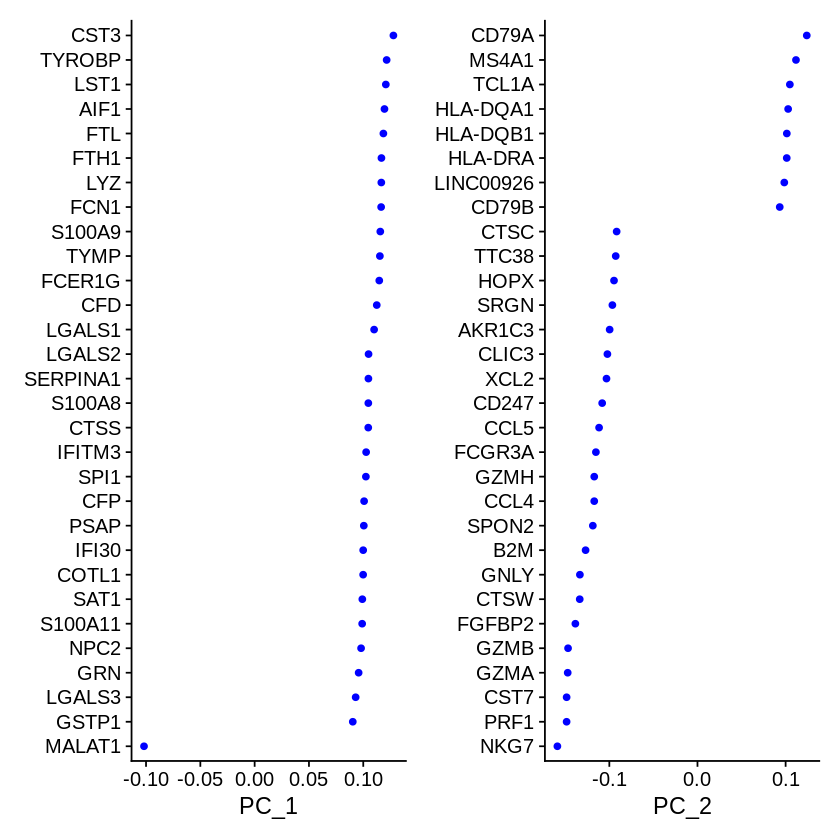

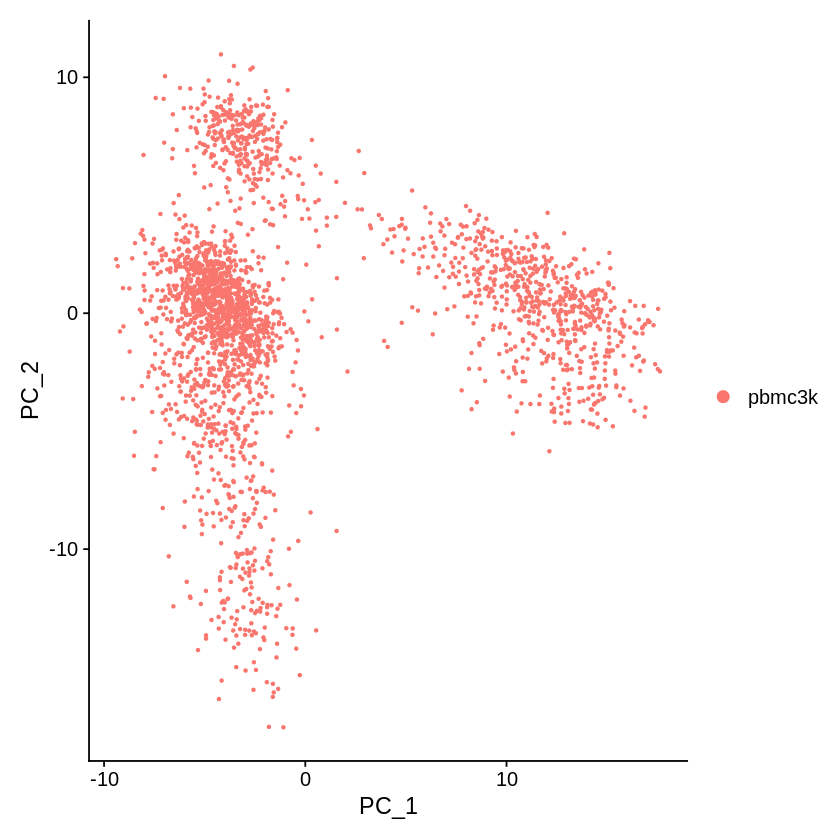

In [30]:
pbmc7 <- RunPCA(pbmc6, features = VariableFeatures(object = pbmc6))

#Seurat provides several useful ways of visualizing both cells and features that define the PCA, including VizDimReduction(), DimPlot(), and DimHeatmap()
# Examine and visualize PCA results a few different ways
print(pbmc7[["pca"]], dims = 1:5, nfeatures = 5)
VizDimLoadings(pbmc7, dims = 1:2, reduction = "pca")

DimPlot(pbmc7, reduction = "pca")

DimHeatmap() allows for easy exploration of the primary sources of heterogeneity in a dataset, and can be useful when trying to decide which PCs to include for further downstream analyses. Both cells and features are ordered according to their PCA scores. Setting cells to a number plots the ‘extreme’ cells on both ends of the spectrum, which dramatically speeds plotting for large datasets. Though clearly a supervised analysis, we find this to be a valuable tool for exploring correlated feature sets.


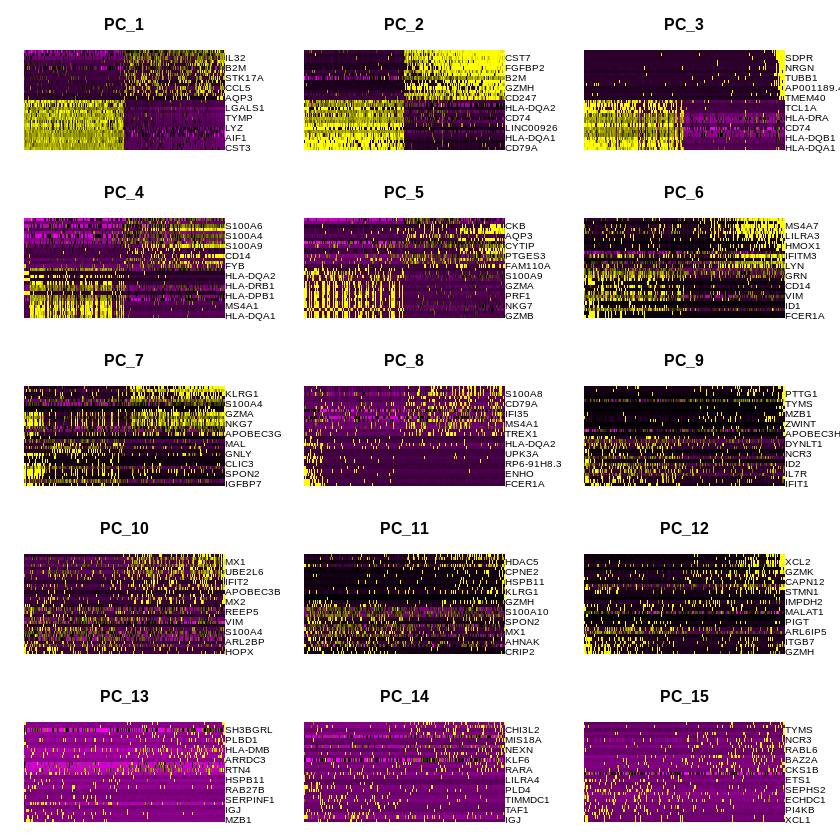

In [31]:
#DimHeatmap(pbmc7, dims = 1, cells = 500, balanced = TRUE)

DimHeatmap(pbmc7, dims = 1:15, cells = 500, balanced = TRUE)

## Determine the ‘dimensionality’ of the dataset
To overcome the extensive technical noise in any single feature for scRNA-seq data, Seurat clusters cells based on their PCA scores, with each PC essentially representing a ‘metafeature’ that combines information across a correlated feature set. The top principal components therefore represent a robust compression of the dataset. However, how many components should we choose to include? 10? 20? 100?

In Macosko et al, we implemented a resampling test inspired by the JackStraw procedure. We randomly permute a subset of the data (1% by default) and rerun PCA, constructing a ‘null distribution’ of feature scores, and repeat this procedure. We identify ‘significant’ PCs as those who have a strong enrichment of low p-value features.

NOTE: This process can take a long time for big datasets, comment out for expediency. More approximate techniques such as those implemented in ElbowPlot() can be used to reduce computation time

```
#pbmc8 <- JackStraw(pbmc7, num.replicate = 100)
#pbmc8 <- ScoreJackStraw(pbmc8, dims = 1:20)
```



### Elow plot
An alternative heuristic method generates an ‘Elbow plot’: a ranking of principle components based on the percentage of variance explained by each one (ElbowPlot() function). In this example, we can observe an ‘elbow’ around PC9-10, suggesting that the majority of true signal is captured in the first 10 PCs.



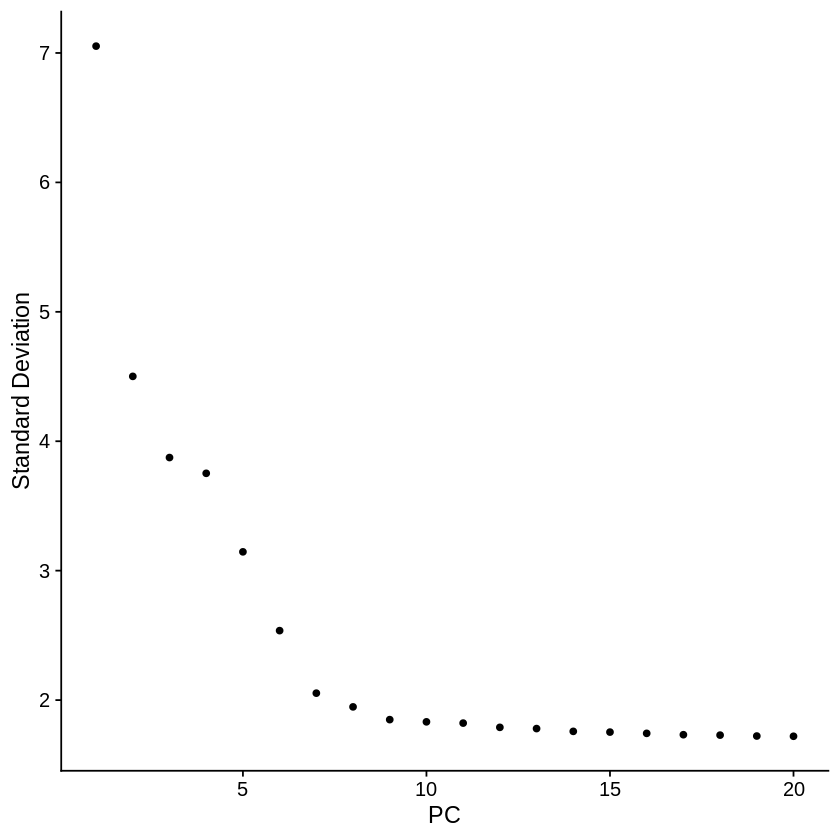

In [32]:
# Elbow plot
ElbowPlot(pbmc7)

Identifying the true dimensionality of a dataset – can be challenging/uncertain for the user. We therefore suggest these three approaches to consider.
* The first is more supervised, exploring PCs to determine relevant sources of heterogeneity, and could be used in conjunction with GSEA for example.
* The second implements a statistical test based on a random null model, but is time-consuming for large datasets, and may not return a clear PC cutoff.
* The third is a heuristic that is commonly used, and can be calculated instantly.

In this example, all three approaches yielded similar results, but we might have been justified in choosing anything between PC 7-12 as a cutoff. We chose 10 PCs here

The Seurat authors advise users to err on the higher side when choosing this parameter. For example, performing downstream analyses with only 5 PCs does significantly and adversely affect results.

## Cluster the cells
Seurat v3 applies a graph-based clustering approach, building upon initial strategies
in (Macosko et al). Importantly, the distance metric which drives the clustering analysis
(based on previously identified PCs) remains the same. However, our approach to partitioning
the cellular distance matrix into clusters has dramatically improved. The approach was heavily
inspired by recent manuscripts which applied graph-based clustering approaches to scRNA-seq data
Briefly, these methods embed cells in a graph structure - for example a **K-nearest neighbor
(KNN) graph**, with edges drawn between cells with similar feature expression patterns, and
then attempt to partition this graph into highly interconnected ‘quasi-cliques’ or
‘communities’.

* As in PhenoGraph, we first construct a KNN graph based on the euclidean distance in PCA space, and refine the edge weights between any two cells based on the shared overlap in their local neighborhoods **(Jaccard similarity)**. This step is performed using the `FindNeighbors()` function, and takes as input the previously defined dimensionality of the dataset (first 10 PCs).
* To cluster the cells, we next apply modularity optimization techniques such as the Louvain algorithm (default) or SLM [SLM, Blondel et al., Journal of Statistical Mechanics], to iteratively group cells together, with the goal of optimizing the standard modularity function. The `FindClusters()` function implements this procedure, and contains a resolution parameter that sets the ‘granularity’ of the downstream clustering, with increased values leading to a greater number of clusters. Setting this parameter between 0.4-1.2 typically returns good results for single-cell datasets of around 3K cells. Optimal resolution often increases for larger datasets. The clusters can be found using the `Idents()` function.


In [33]:
pbmc8 <- FindNeighbors(pbmc7, dims = 1:10)
pbmc8 <- FindClusters(pbmc8, resolution = 0.5)
#Number of nodes: 2638
#Number of edges: 95905

# Look at cluster IDs of the first 5 cells
head(Idents(pbmc8), 5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95893

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8735
Number of communities: 9
Elapsed time: 0 seconds


AAACATACAACCAC-1 AAACATTGAGCTAC-1 AAACATTGATCAGC-1 AAACCGTGCTTCCG-1 
               0                3                2                1 
AAACCGTGTATGCG-1 
               6 
Levels: 0 1 2 3 4 5 6 7 8

## Run non-linear dimensional reduction (UMAP/tSNE)
Seurat offers several non-linear dimensional reduction techniques, such as tSNE and UMAP, to visualize and explore these datasets. The goal of these algorithms is to learn the underlying manifold of the data in order to place similar cells together in low-dimensional space. Cells within the graph-based clusters determined above should co-localize on these dimension reduction plots. As input to the UMAP and tSNE, we suggest using the same PCs as input to the clustering analysis.


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
02:52:57 UMAP embedding parameters a = 0.9922 b = 1.112

02:52:58 Read 2638 rows and found 10 numeric columns

02:52:58 Using Annoy for neighbor search, n_neighbors = 30

02:52:58 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

02:52:58 Writing NN index file to temp file /tmp/RtmpF8EIv7/file1a665b32d4c

02:52:58 Searching Annoy index using 1 thread, search_k = 3000

02:52:59 Annoy recall = 100%

02:53:00 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 

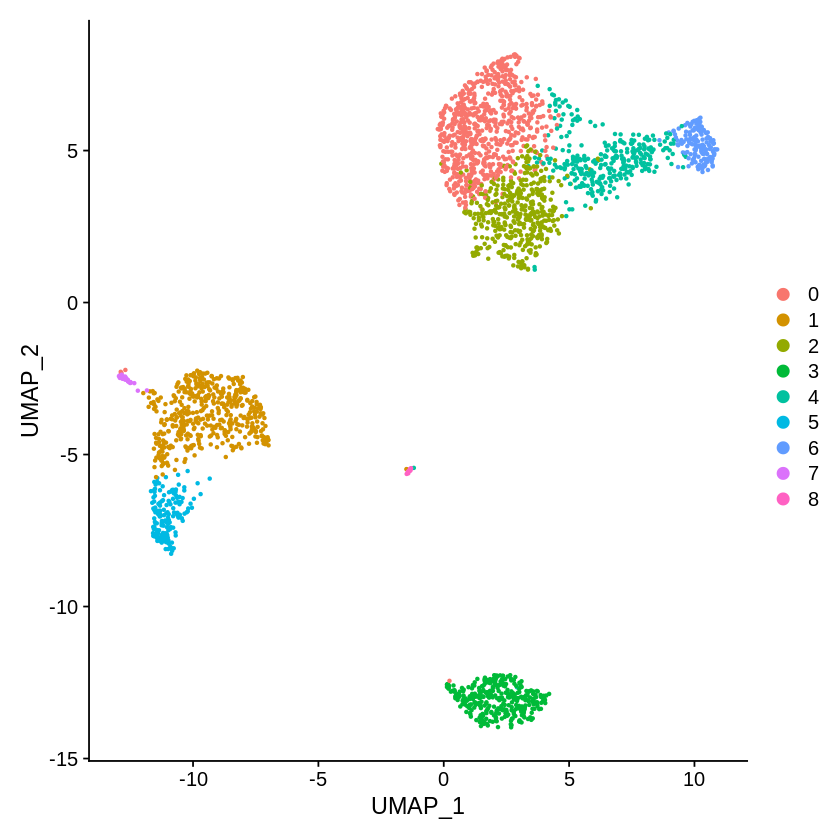

In [34]:
# If you haven't installed UMAP, you can do so via reticulate::py_install(packages =
#'umap-learn')
pbmc9 <- RunUMAP(pbmc8, dims = 1:10)

# note that you can set `label = TRUE` or use the LabelClusters function to help label
#individual clusters
DimPlot(pbmc9, reduction = "umap")

#You can save the object at this point so that it can easily be loaded back in without
#having to rerun the computationally intensive steps performed above, or easily shared with collaborators.

saveRDS(pbmc9, file = "/content/sample_data/Seurat_pbmc_tutorial.rds")

## Finding differentially expressed features (cluster biomarkers)
Seurat can help find markers that define clusters via differential expression. By default, it identifies positive and negative markers of a single cluster (specified in ident.1), compared to all other cells. FindAllMarkers() automates this process for all clusters, but you can also test groups of clusters vs. each other, or against all cells.

The min.pct argument requires a feature to be detected at a minimum percentage in either of the two groups of cells, and the thresh.test argument requires a feature to be differentially expressed (on average) by some amount between the two groups. You can set both of these to 0, but with a dramatic increase in time - since this will test a large number of features that are unlikely to be highly discriminatory. As another option to speed up these computations, max.cells.per.ident can be set. This will downsample each identity class to have no more cells than whatever this is set to. While there is generally going to be a loss in power, the speed increases can be significant and the most highly differentially expressed features will likely still rise to the top.

Find all markers of cluster 2


In [35]:
cluster2.markers <- FindMarkers(pbmc9,
                                ident.1 = 2,
                                min.pct = 0.25)
head(cluster2.markers, n = 5)

For a more efficient implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the limma package
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('limma')
--------------------------------------------
After installation of limma, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session



,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IL32,1.616287e-80,1.1350656,0.951,0.475,2.216576e-76
LTB,1.931941e-80,1.2727422,0.981,0.650,2.649464e-76
LDHB,5.248695e-65,0.9390949,0.967,0.618,7.198060e-61
CD3D,1.379097e-61,0.8797194,0.916,0.443,1.891293e-57
IL7R,7.116417e-60,1.1636337,0.748,0.335,9.759454e-56


Find all markers distinguishing cluster 5 from clusters 0 and 3


In [36]:
# find all markers distinguishing cluster 5 from clusters 0 and 3
cluster5.markers <- FindMarkers(pbmc9,
                                ident.1 = 5,
                                ident.2 = c(0, 3),
                                min.pct = 0.25)

Find markers for every cluster compared to all remaining cells, report only the positive ones


In [37]:
pbmc.markers <- FindAllMarkers(pbmc9,
                               only.pos = TRUE,
                               min.pct = 0.25,
                               logfc.threshold = 0.25)

pbmc.markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
5.014988e-85,1.343454,0.437,0.108,6.877554e-81,0,CCR7
1.877029e-117,1.079415,0.913,0.588,2.574157e-113,0,LDHB
0.000000e+00,5.570063,0.996,0.215,0.000000e+00,1,S100A9
0.000000e+00,5.477394,0.975,0.121,0.000000e+00,1,S100A8
1.931941e-80,1.272742,0.981,0.650,2.649464e-76,2,LTB
2.905337e-58,1.269532,0.667,0.251,3.984379e-54,2,CD2
0.000000e+00,4.314919,0.939,0.042,0.000000e+00,3,CD79A
1.055671e-269,3.586567,0.623,0.022,1.447748e-265,3,TCL1A
3.596264e-221,3.212259,0.984,0.226,4.931916e-217,4,CCL5


Seurat has several tests for differential expression which can be set with the test.use parameter (see our DE vignette for details). For example, the ROC test returns the ‘classification power’ for any individual marker (ranging from 0 - random, to 1 - perfect).

In [38]:
cluster0.markers <- FindMarkers(pbmc9,
                                ident.1 = 0,
                                logfc.threshold = 0.25,
                                test.use = "roc",
                                only.pos = TRUE)
head(cluster0.markers)

,myAUC,avg_diff,power,avg_log2FC,pct.1,pct.2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RPS12,0.831,0.5132163,0.662,0.7404146,1.000,0.991
RPS6,0.828,0.4730236,0.656,0.6824288,1.000,0.995
RPL32,0.824,0.4362054,0.648,0.6293113,0.999,0.995
RPS27,0.821,0.5010227,0.642,0.7228229,0.999,0.992
RPS14,0.815,0.4366673,0.630,0.6299777,1.000,0.994
RPS25,0.811,0.5381009,0.622,0.7763155,0.997,0.975


## Visulize markers
There are several tools for visualizing marker expression.
* VlnPlot() (shows expression probability distributions across clusters), and * FeaturePlot() (visualizes feature expression on a tSNE or PCA plot) are the most commonly used visualizations.
* RidgePlot(), CellScatter(), and DotPlot()

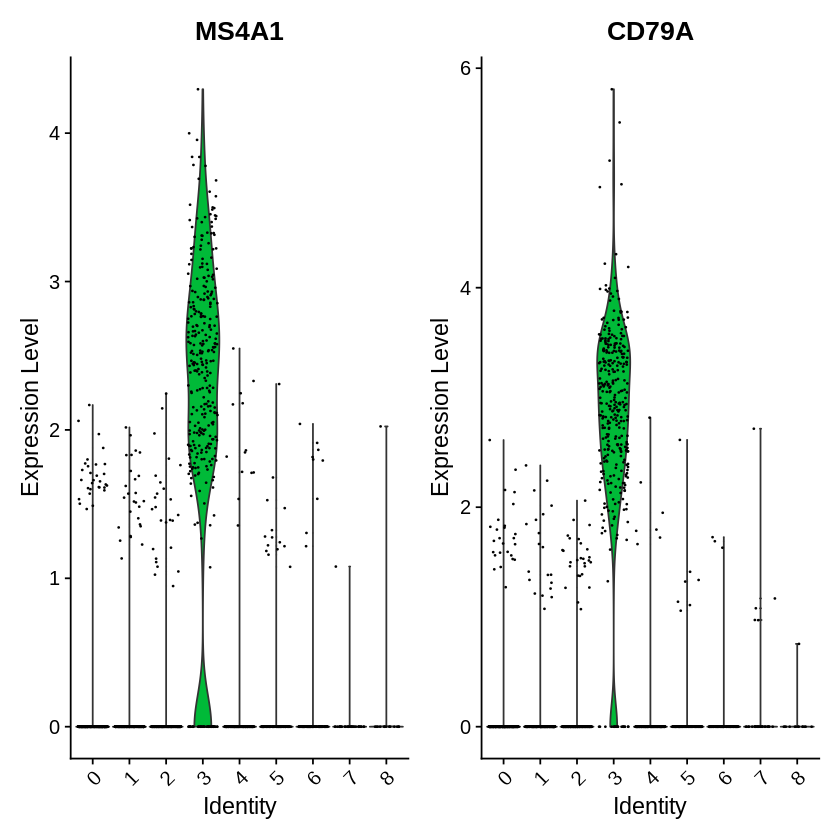

In [39]:
VlnPlot(pbmc9, features = c("MS4A1", "CD79A"))


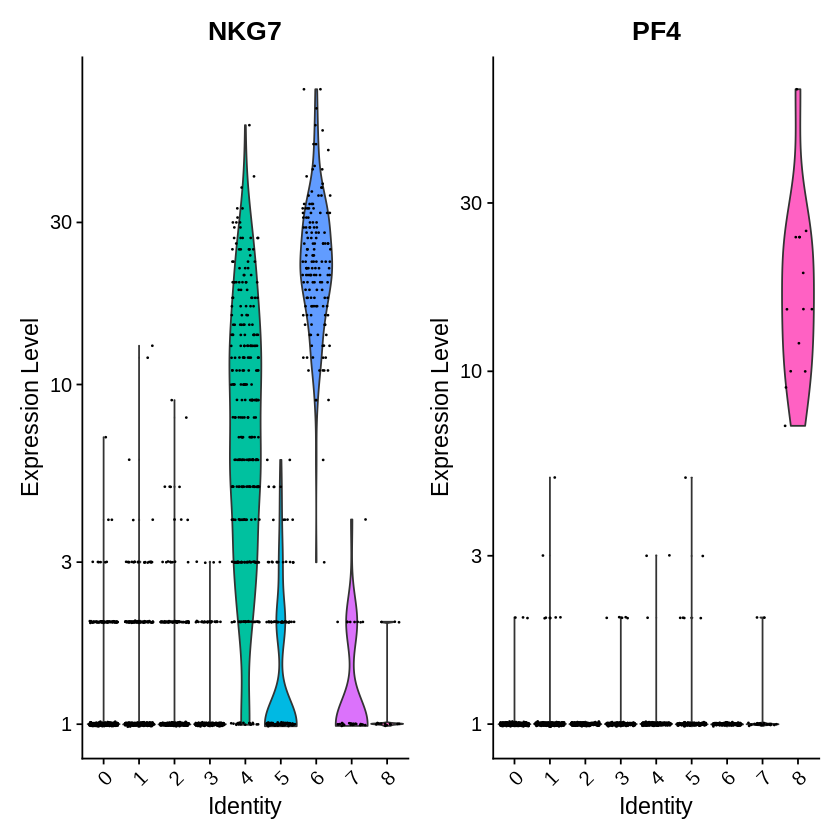

In [40]:
#Can plot raw counts as well
VlnPlot(pbmc9, features = c("NKG7", "PF4"), slot = "counts", log = TRUE)

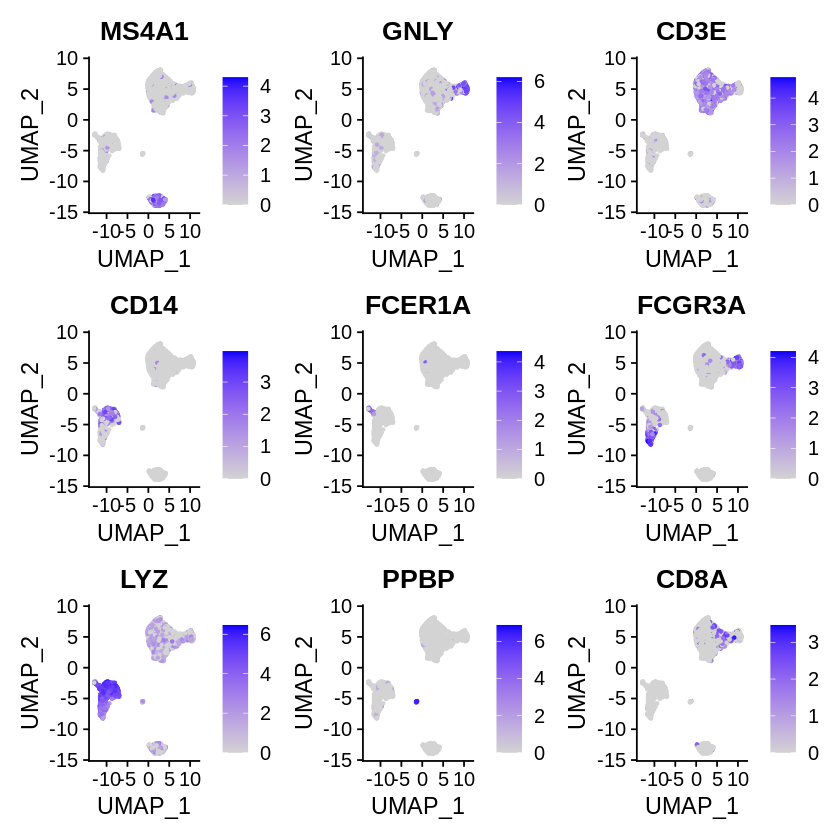

In [41]:
FeaturePlot(pbmc9,
    features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP", "CD8A"))

DoHeatmap() generates an expression heatmap for given cells and features. In this case, we are plotting the top 20 markers (or all markers if less than 20) for each cluster.


Warning message in DoHeatmap(pbmc9, features = top10$gene):
“The following features were omitted as they were not found in the scale.data slot for the RNA assay: CD8A, VPREB3, CD40LG, PIK3IP1, PRKCQ-AS1, NOSIP, LEF1, CD3E, CD3D, CCR7, LDHB, RPS3A”


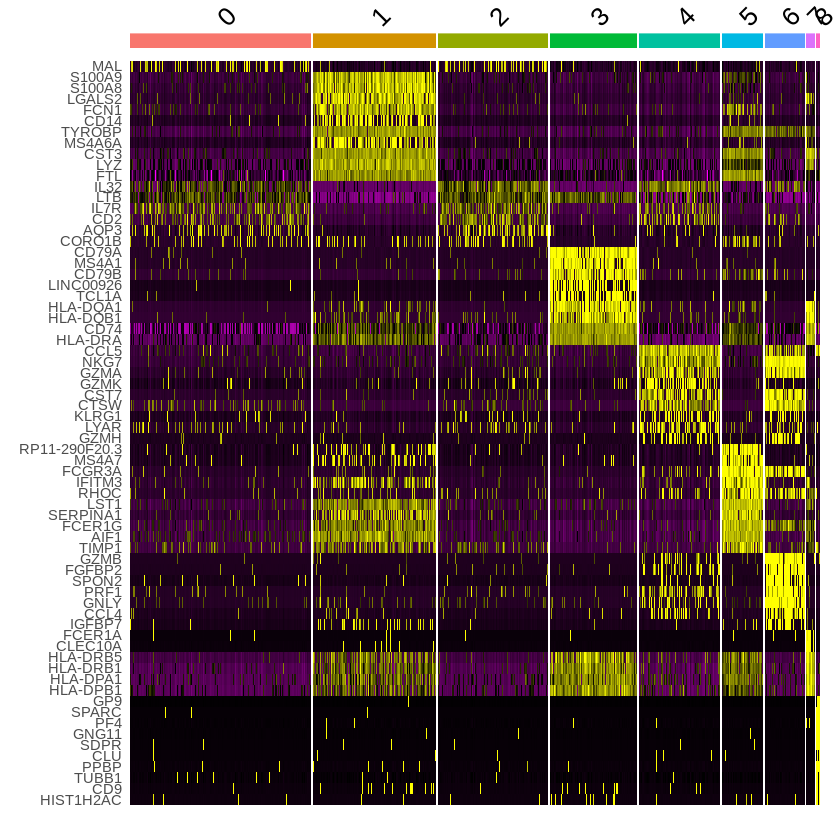

In [42]:
pbmc.markers %>%
    group_by(cluster) %>%
    top_n(n = 10, wt = avg_log2FC) -> top10

DoHeatmap(pbmc9, features = top10$gene) + NoLegend()

## Assigning cell type identity to clusters
we can use canonical markers to easily match the unbiased clustering to known cell types
Cluster ID	Markers	Cell Type
0	IL7R, CCR7	Naive CD4+ T
1	CD14, LYZ	CD14+ Mono
2	IL7R, S100A4	Memory CD4+
3	MS4A1	B
4	CD8A	CD8+ T
5	FCGR3A, MS4A7	FCGR3A+ Mono
6	GNLY, NKG7	NK
7	FCER1A, CST3	DC
8	PPBP	Platelet

In [43]:
new.cluster.ids <- c("Naive CD4 T", "CD14+ Mono", "Memory CD4 T", "B", "CD8 T", "FCGR3A+ Mono",
    "NK", "DC", "Platelet")
names(new.cluster.ids) <- levels(pbmc9)
pbmc10 <- RenameIdents(pbmc9, new.cluster.ids)

saveRDS(pbmc10, file = "/content/sample_data/Seurat_pbmc3k_final.rds")

In [ ]:
#Write session info
sessionInfo()


## Tutorial complete
The tutorial is now complete. Please download the two RDS files exported to the output directory '/content/sample_data/', and the images generated



## References
* https://satijalab.org/seurat/articles/pbmc3k_tutorial.html